In [82]:
!pip install shap
!pip install eli5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from google.colab import drive
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ProcessPoolExecutor
import logging
from sklearn.feature_selection import SelectFromModel
import shap
import eli5
from eli5.sklearn import PermutationImportance




In [83]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
df=pd.read_csv('/content/drive/My Drive/archive/bird_songs_metadata.csv')
df.head()

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [85]:
# List for storing the filepaths and labels
file_paths = []
labels = []
audio_dir = '/content/drive/MyDrive/archive/wavfiles/'

for filename, species in df[['filename', 'species']].itertuples(index=False):
    file_path = Path(audio_dir) / filename
    if file_path.exists():
        file_paths.append(str(file_path))
        labels.append(species)
    else:
        print(f"File not found: {file_path}")

#first five elements of each list
print(file_paths[:5])
print(labels[:5])

['/content/drive/MyDrive/archive/wavfiles/557838-0.wav', '/content/drive/MyDrive/archive/wavfiles/557838-1.wav', '/content/drive/MyDrive/archive/wavfiles/557838-4.wav', '/content/drive/MyDrive/archive/wavfiles/557838-5.wav', '/content/drive/MyDrive/archive/wavfiles/557838-6.wav']
['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii']


In [86]:
#load and process audio files from paths
def load_and_process_audio(file_paths, sr, fixed_length):
    processed_audio = []
    for file_path in file_paths:
        sound, _ = librosa.load(file_path, sr=sr)
        if len(sound) > fixed_length:
            sound = sound[:fixed_length]
        else:
            padding = fixed_length - len(sound)
            sound = np.pad(sound, (0, padding), 'constant')
        processed_audio.append(sound)
    return processed_audio

In [88]:
# Function to extract mfcc features
def extract_features(audio_clips, sr):
    mfcc_features = []
    for sound in audio_clips:
        mfcc = librosa.feature.mfcc(y=sound, sr=sr, n_mfcc=13)
        mfcc_scaled = np.mean(mfcc.T, axis=0)
        mfcc_features.append(mfcc_scaled)
    return np.array(mfcc_features)

# Variables
fixed_length = 5 * 22050  # 5 seconds multiplied by sampling rate
sr = 22050  # Default sampling rate from librosa


# Load and process audio files
processed_audio = load_and_process_audio(file_paths, sr, fixed_length)

# Extract features
features = extract_features(processed_audio, sr)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

# Train-test split
X_train, X_test, y_train, y_test, files_train, files_test = train_test_split(features, y_encoded, file_paths, test_size=0.2, random_state=42)


In [89]:
# Initialize the model
xg_model = XGBClassifier(random_state=42)

# Train the model
xg_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_model.predict(X_test)

In [90]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8912442396313364


In [91]:
print("Classification Report", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report               precision    recall  f1-score   support

    bewickii       0.88      0.87      0.87       193
  cardinalis       0.92      0.88      0.90       204
     melodia       0.87      0.91      0.89       243
 migratorius       0.88      0.93      0.91       207
 polyglottos       0.91      0.87      0.89       238

    accuracy                           0.89      1085
   macro avg       0.89      0.89      0.89      1085
weighted avg       0.89      0.89      0.89      1085



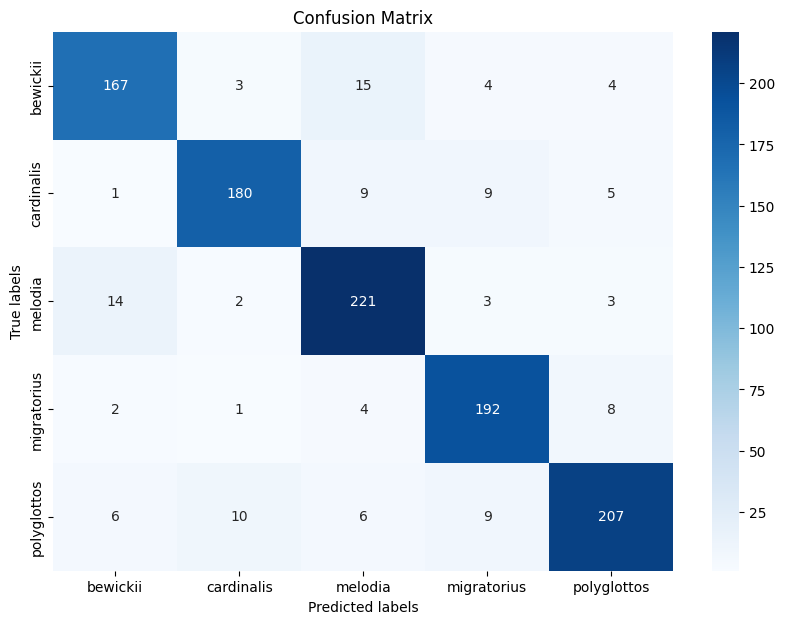

In [92]:
#confusion Matrix
cm = confusion_matrix(y_test, y_pred)

#Plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

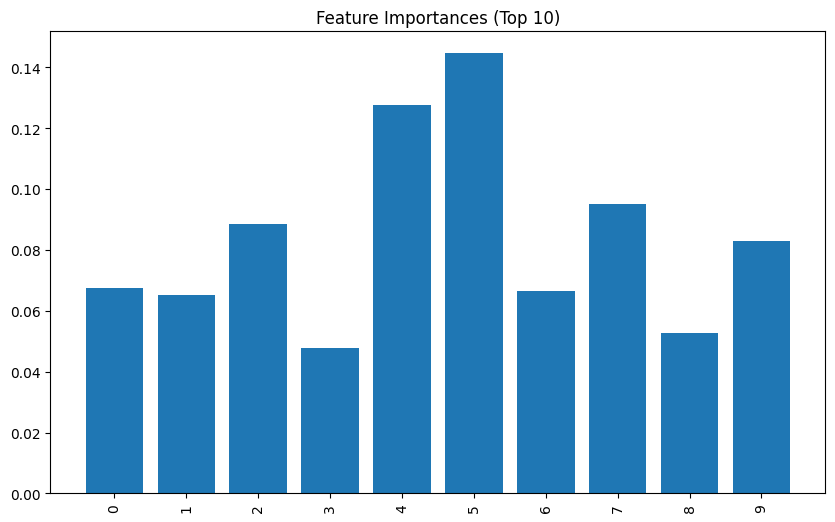

In [93]:
# Get feature importances
importances = xg_model.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(10), importances[:10])
plt.xticks(range(10), range(10), rotation=90)
plt.title('Feature Importances (Top 10)')
plt.show()

In [94]:
incorrect_indices = [i for i, (pred, actual) in enumerate(zip(y_pred, y_test)) if pred != actual]
print(incorrect_indices)

[5, 13, 25, 26, 35, 50, 67, 82, 85, 95, 98, 99, 102, 106, 119, 151, 161, 186, 204, 205, 206, 215, 221, 228, 235, 246, 255, 257, 271, 272, 277, 285, 287, 290, 307, 324, 332, 334, 343, 346, 370, 398, 404, 410, 413, 418, 427, 454, 455, 476, 477, 478, 480, 486, 495, 500, 511, 515, 529, 532, 537, 558, 572, 575, 576, 585, 586, 622, 634, 636, 645, 648, 650, 652, 656, 658, 680, 686, 691, 702, 705, 721, 722, 723, 730, 736, 778, 779, 788, 795, 796, 807, 810, 814, 833, 862, 865, 869, 888, 890, 920, 931, 932, 940, 944, 946, 962, 967, 969, 976, 982, 1018, 1045, 1047, 1049, 1060, 1065, 1068]


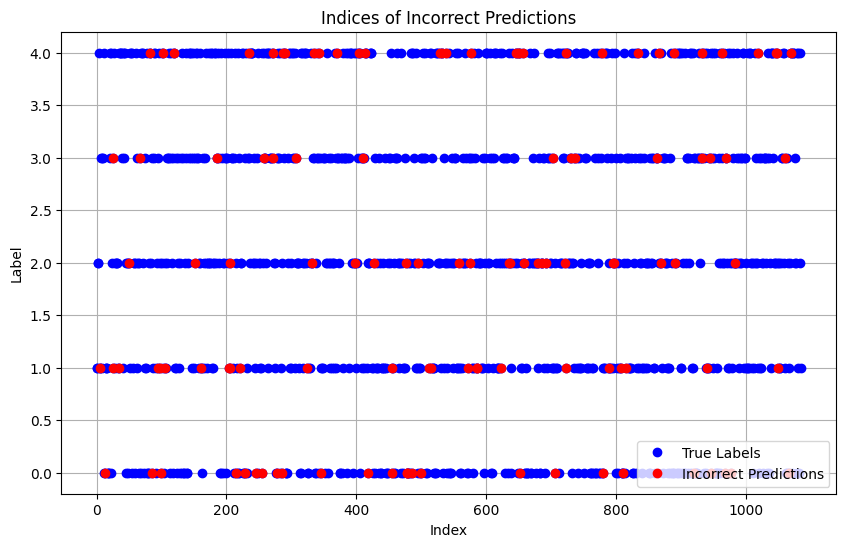

In [95]:
# Plotting the indices of incorrect predictions
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, 'bo', label='True Labels')
plt.plot(incorrect_indices, [y_test[i] for i in incorrect_indices], 'ro', label='Incorrect Predictions')
plt.title('Indices of Incorrect Predictions')
plt.xlabel('Index')
plt.ylabel('Label')
plt.legend()
plt.grid(True)
plt.show()

In [96]:
# Create the SHAP explainer object. TreeExplainer is specialized for tree-based models like XGBoost
explainer = shap.TreeExplainer(xg_model)

# Calculate the SHAP values for the test set
shap_values = explainer.shap_values(X_test)


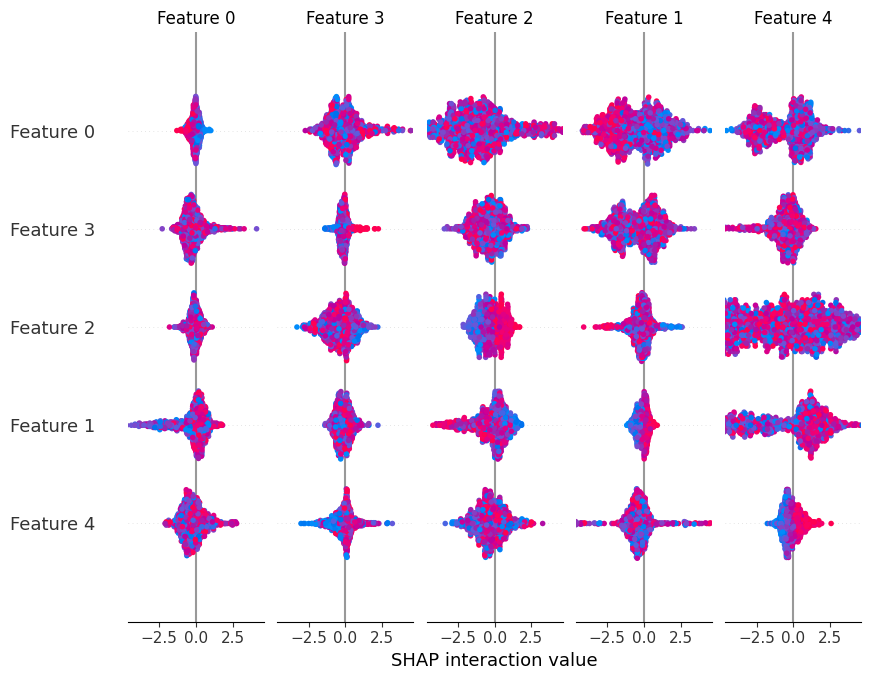

In [98]:
# For a detailed visualization, use a beeswarm plot
shap.summary_plot(shap_values, X_test)